In [ ]:
import torch

CONTENT_FILE = './input/boy/input_boy.wav'
STYLE_FILE = './input/girl/input_girl.wav'

learning_rate = 0.001

content_weight = 10.0
style_weight = 1.0

sampleRate = None # Use native sample rate
N_FFT = 512

print_period = 100
max_epochs = 20000

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

(155576,) (192, 811)
(187706,) (192, 978)
sample rate: 44010


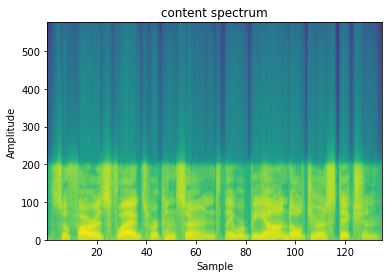

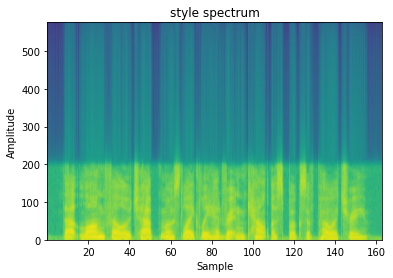

In [ ]:
# from processing import *
from utils import *
import torch


x_content = loadFile(CONTENT_FILE)
x_style = loadFile(STYLE_FILE)

a_content = wav2spectrum(x_content)
a_style = wav2spectrum(x_style)

print(x_content.shape, a_content.shape)
print(x_style.shape, a_style.shape)
print(f'sample rate: {sampleRate}')

plot_spectrogram_with_raw_signal(x_content, N_FFT, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style, N_FFT, 'style spectrum')


# Training

In [14]:
import torch.optim as optim
from models import *


model = RandomCNN()
model.eval()



a_C = torch.tensor(a_content[None, None, :, :], requires_grad = False, device = device).float()
a_S = torch.tensor(a_style[None, None, :, :], requires_grad = False, device = device).float()


# optimizer
a_G_var = torch.randn(a_C.shape, device = device) * 0.001
a_G_var.requires_grad = True

optimizer = optim.Adam(
    params = [a_G_var],
    lr = learning_rate,
)

model.to(device)

a_C = model(a_C)
a_S = model(a_S)


losses = []
style_losses = []
content_losses = []

for epoch in range(1, max_epochs + 1):

    optimizer.zero_grad()
    a_G = model(a_G_var)
    
    content_loss = content_weight * RandomCNN.compute_content_loss(a_C, a_G)
    style_loss = style_weight * RandomCNN.compute_layer_style_loss(a_S, a_G)

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    if epoch % print_period == 0:
        print('{}/{} content_loss: {:4f}, style_loss: {:4f}, total_loss: {:4f}'.format(
            epoch,
            max_epochs,
            content_loss,
            style_loss,
            loss
        ))

    losses.append(loss.detach().cpu())
    content_losses.append(content_loss.detach().cpu())
    style_losses.append(style_loss.detach().cpu())

gen_spectrum = a_G_var.cpu().data.numpy().squeeze()


100/20000 content_loss: 1.328370, style_loss: 26800.390625, total_loss: 26801.718750
200/20000 content_loss: 0.909384, style_loss: 18651.146484, total_loss: 18652.056641
300/20000 content_loss: 0.746323, style_loss: 10967.841797, total_loss: 10968.587891
400/20000 content_loss: 0.649747, style_loss: 6293.367188, total_loss: 6294.017090
500/20000 content_loss: 0.566348, style_loss: 3508.739014, total_loss: 3509.305420
600/20000 content_loss: 0.510293, style_loss: 1919.591797, total_loss: 1920.102051
700/20000 content_loss: 0.480063, style_loss: 1137.090332, total_loss: 1137.570435
800/20000 content_loss: 0.466449, style_loss: 817.796692, total_loss: 818.263123
900/20000 content_loss: 0.461168, style_loss: 706.192932, total_loss: 706.654114
1000/20000 content_loss: 0.459952, style_loss: 666.325867, total_loss: 666.785828
1100/20000 content_loss: 0.461171, style_loss: 642.702881, total_loss: 643.164062
1200/20000 content_loss: 0.464633, style_loss: 615.619019, total_loss: 616.083679
1300/

# plot loss curve

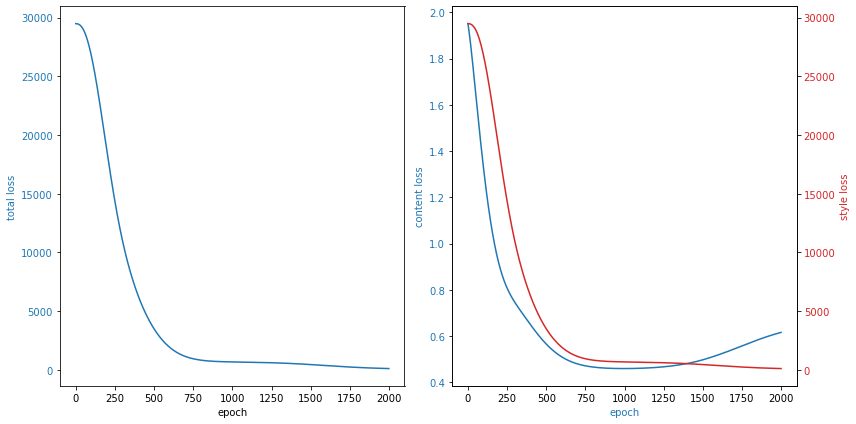

In [15]:
import utils

utils.plot_curve(content_losses, style_losses, losses, same_y_scale=False)

# Save file

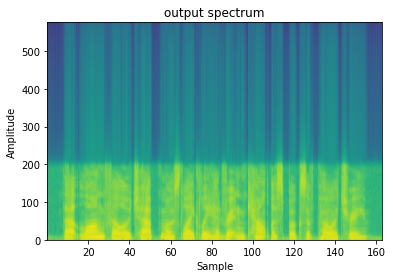

In [16]:
import os

filename = 'randomCNN.wav'

x = spectrum2wav(gen_spectrum)

x = scale_audio(x, 20)
writeFile(os.path.join('./output/', filename), x)

plot_spectrogram_with_raw_signal(x_style, N_FFT, 'output spectrum')


# 